# Email Spam Detection
### Dataset

In [1]:

import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score

# data from https://www.kaggle.com/datasets/rockinjas123/spam-ham-emails
data = pd.read_csv('emails.csv')
data


,text,spam
0,Subject: naturally irresistible your corporate...,1
1,Subject: the stock trading gunslinger fanny i...,1
2,Subject: unbelievable new homes made easy im ...,1
3,Subject: 4 color printing special request add...,1
4,"Subject: do not have money , get software cds ...",1
...,...,...
5723,Subject: re : research and development charges...,0
5724,"Subject: re : receipts from visit jim , than...",0
5725,Subject: re : enron case study update wow ! a...,0
5726,"Subject: re : interest david , please , call...",0


### Data Pre-Processing

In [2]:
print(f"Rows Before Pre-Pocessing: {len(data.index)}")

# drops duplicate rows. no need to have too many rows of the same values
data.drop_duplicates(inplace=True)

# since there are only 2 columns if any of them are null then those rows dont serve any functions
data.dropna(axis = 'index')

print(f"Rows After Pre-Pocessing: {len(data.index)}")

Rows Before Pre-Pocessing: 5728
Rows After Pre-Pocessing: 5695


In [3]:
x = data.text.values
y = data.spam.values
xTrain, xTest, yTrain, yTest = train_test_split(x, y, train_size = 0.8, stratify = y)

In [4]:
from sklearn.feature_extraction.text import CountVectorizer

cv = CountVectorizer()

# converting word to numbers via counting word frequencies: eg. "i hate spam. spam is bad" -> i = 1, hate = 1, spam = 2, is = 1, bad = 1
xTrain_cv = cv.fit_transform(xTrain)
xTest_cv = cv.transform(xTest)

##### Correlation

In [6]:

cvDf = pd.DataFrame(xTrain_cv.todense(), columns=cv.get_feature_names_out())
cvDf['spam@unique'] = yTrain
correlation = cvDf.corrwith(cvDf['spam@unique'])
correlation

00            -0.061410
000            0.097323
0000           0.119991
000000         0.026358
00000000      -0.013604
                 ...   
zzmacmac      -0.008329
zzn            0.026358
zzncacst      -0.008329
zzzz           0.045663
spam@unique    1.000000
Length: 33515, dtype: float64

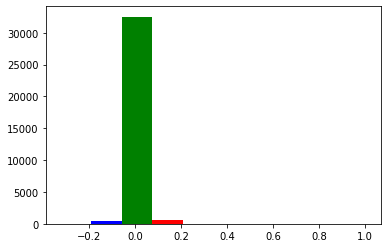

In [7]:
import matplotlib.pyplot as plt

N, bins, patches  = plt.hist(correlation)


patches[1].set_facecolor('blue')
patches[2].set_facecolor('green')
patches[3].set_facecolor('red')
# rest are default colors

plt.show()

Since all of the word frequencies(x-variables) have almost no correlation with whether the email being spam or not (y), it can be concluded that the x-variables are not independent among each other. The x-variables are most likely dependant among each other.

##### Scaling

In [8]:
from sklearn.preprocessing import MaxAbsScaler

mas = MaxAbsScaler()
mas.fit(xTrain_cv)
xTrainScaled = mas.transform(xTrain_cv)
xTestScaled = mas.transform(xTest_cv)

### Modelling Data

In [9]:
def modelData(model, scaled=True):
  x = xTrainScaled if scaled else xTrain_cv
  y = yTrain
  model.fit(x,y)
  return model

In [10]:
def display_score(trained_model, scaled = True):
  x = xTestScaled if scaled else xTest_cv
  y = yTest
  y_pred = trained_model.predict(x)
  acc = trained_model.score(x, y)
  prec = precision_score(y, y_pred)
  f1scre = f1_score(y, y_pred)
  recal = recall_score(y, y_pred)

  print(f"Accuracy: {acc}\nPrecision: {prec}\nF1 Score: {f1scre}\nRecall Score: {recal}")

In [11]:
customTests = [
  "Hello sir! When is the deadline for CSE422 project report submission?",
  "Dear Students, The University is happy to offer a student transport service and wishes to keep the price as low as feasible while covering the cost of the service. You all know that the price of fuel has increased significantly: the price of diesel has increased by 42.5% (Previous price- Tk.80, New price Tk.114).Bus fares have already been raised across the country. Despite the increase in the fuel price, the University will keep the student transport fares unchanged for the remainder of the current semester. There will be a need, however, to increase the fare to Tk. 90 from Tk.70 with effect from the start of the fall semester. The University hopes that you will understand the pressures that have led to this change. Best regards, Office of the Registrar",
  "ONLY BOYS CHECK MY BIO 😳🔞",
  "Click here to get free discord nitro"
  ]
customTests_cv = cv.transform(customTests)
customTestsScaled = mas.transform(customTests_cv)

def getCustomTestResults(model, scaled=True):

  results = model.predict(customTestsScaled if scaled else customTests_cv)
  assert len(results) == len(customTests), f"length of results, {len(results)} and tests, {len(customTests)} are unequal"
  for i in range(len(results)):
    spam = "spam" if results[i] == 1 else "ok"
    if len(customTests[i]) > 80:
      print(f"{spam}  -->  \"{customTests[i][0:35]} ... {customTests[i][-35:]}\"")
    else:
      print(f"{spam}  -->  \"{customTests[i]}\"")

##### Multinomial Naive Bayes

In [12]:
from sklearn.naive_bayes import MultinomialNB as MNB

# scaled
mnbModelScaled = modelData(MNB())

display_score(mnbModelScaled)

getCustomTestResults(mnbModelScaled)

Accuracy: 0.9850746268656716
Precision: 0.9885931558935361
F1 Score: 0.9683426443202979
Recall Score: 0.948905109489051
ok  -->  "Hello sir! When is the deadline for CSE422 project report submission?"
ok  -->  "Dear Students, The University is ha ... st regards, Office of the Registrar"
ok  -->  "ONLY BOYS CHECK MY BIO 😳🔞"
ok  -->  "Click here to get free discord nitro"


In [13]:
mnbModel = modelData(MNB(), False)

display_score(mnbModel, False)

getCustomTestResults(mnbModel, False)

Accuracy: 0.9938542581211589
Precision: 0.9819494584837545
F1 Score: 0.9872958257713249
Recall Score: 0.9927007299270073
ok  -->  "Hello sir! When is the deadline for CSE422 project report submission?"
ok  -->  "Dear Students, The University is ha ... st regards, Office of the Registrar"
spam  -->  "ONLY BOYS CHECK MY BIO 😳🔞"
spam  -->  "Click here to get free discord nitro"


##### Support Vector Classifier

In [14]:
from sklearn.svm import SVC

# scaled
svcModelScaled = modelData( SVC(kernel="linear") )

display_score(svcModelScaled )

getCustomTestResults(svcModelScaled )

Accuracy: 0.9692712906057945
Precision: 0.9686274509803922
F1 Score: 0.9338374291115311
Recall Score: 0.9014598540145985
ok  -->  "Hello sir! When is the deadline for CSE422 project report submission?"
ok  -->  "Dear Students, The University is ha ... st regards, Office of the Registrar"
ok  -->  "ONLY BOYS CHECK MY BIO 😳🔞"
ok  -->  "Click here to get free discord nitro"


In [15]:
svcModel = modelData( SVC(kernel="linear") , False)

display_score(svcModel, False)

getCustomTestResults(svcModel, False)

Accuracy: 0.9859525899912204
Precision: 0.9777777777777777
F1 Score: 0.9705882352941176
Recall Score: 0.9635036496350365
ok  -->  "Hello sir! When is the deadline for CSE422 project report submission?"
ok  -->  "Dear Students, The University is ha ... st regards, Office of the Registrar"
ok  -->  "ONLY BOYS CHECK MY BIO 😳🔞"
spam  -->  "Click here to get free discord nitro"


##### Random Forest Classifier

In [16]:
from sklearn.ensemble import RandomForestClassifier as RFC

# scaled
rfcModelScaled = modelData(RFC(n_estimators=50))

display_score(rfcModelScaled)

getCustomTestResults(rfcModelScaled)

Accuracy: 0.9692712906057945
Precision: 0.995850622406639
F1 Score: 0.9320388349514563
Recall Score: 0.8759124087591241
ok  -->  "Hello sir! When is the deadline for CSE422 project report submission?"
ok  -->  "Dear Students, The University is ha ... st regards, Office of the Registrar"
ok  -->  "ONLY BOYS CHECK MY BIO 😳🔞"
ok  -->  "Click here to get free discord nitro"


In [17]:
rfcModel = modelData(RFC(n_estimators=50), False)

display_score(rfcModel, False)

getCustomTestResults(rfcModel, False)

Accuracy: 0.9727831431079894
Precision: 1.0
F1 Score: 0.9400386847195358
Recall Score: 0.8868613138686131
ok  -->  "Hello sir! When is the deadline for CSE422 project report submission?"
ok  -->  "Dear Students, The University is ha ... st regards, Office of the Registrar"
ok  -->  "ONLY BOYS CHECK MY BIO 😳🔞"
spam  -->  "Click here to get free discord nitro"
